#Overview & motivation

All of our team members enjoy movies. In addition to enjoying movies, we also enjoy working with API’s and somewhat structured data sets. Therefore, determining what makes a movie successful using the data available in the Internet Movie Database (IMDB) and Wikipedia seemed like a natural choice.

In [2]:
from imdb import IMDb
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import cPickle as pickle
ia = IMDb(accessSystem='http')
from collections import defaultdict 
import io
from datetime import datetime
import time
from sklearn.linear_model import LogisticRegression, ElasticNet
import sklearn.svm
import math
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

###Related Work

#Initial Questions

#Data

###Import Data

Because the goal of this aspect of our project is to attempt to predict Oscar winners from those nominated, we First we split our data into a test set (movies in 2006) and a training set (movies 1981-2005).  We will use k-fold cross validation to train our model.  In this preliminary analysis, we train our model to predict Oscar winners given the movie was nominated.

In [25]:
# Load AAdict (dict of Oscar nominated movies)
AAdf = pd.DataFrame.from_dict(pickle.load(open('AAdictfinal_copy.p','rb'))).transpose()
AAdf.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,France,Germany,History,Horror,Italy,Music,Musical,Mystery,News,Nominated Best Actor,Nominated Best Actress,Nominated Best Animated Feature Film,Nominated Best Art Direction,Nominated Best Cinematography,Nominated Best Costume Design,Nominated Best Director,"Nominated Best Documentary, Feature","Nominated Best Documentary, Short Subject",Nominated Best Film Editing,Nominated Best Foreign Language Film,Nominated Best Makeup,"Nominated Best Music, Adaptation / Original Song Score","Nominated Best Music, Dramatic Score","Nominated Best Music, Musical or Comedy Score","Nominated Best Music, Original Score","Nominated Best Music, Song",Nominated Best Picture,"Nominated Best Short Film, Animated","Nominated Best Short Film, Live Action",Nominated Best Sound,Nominated Best Sound Editing,Nominated Best Sound Effects Editing,Nominated Best Sound Mixing,Nominated Best Supporting Actor,Nominated Best Supporting Actress,Nominated Best Visual Effects,"Nominated Best Writing, Adapted Screenplay","Nominated Best Writing, Original Screenplay",Nominated Special Achievement Award,OtherCountry,...,"Won Best Short Film, Animated","Won Best Short Film, Live Action",Won Best Sound,Won Best Sound Editing,Won Best Sound Effects Editing,Won Best Sound Mixing,Won Best Supporting Actor,Won Best Supporting Actress,Won Best Visual Effects,"Won Best Writing, Adapted Screenplay","Won Best Writing, Original Screenplay",Won Special Achievement Award,based-on-novel,blockbuster,blood,cast,character-name-in-title,cigarette-smoking,cult-film,dancing,death,director,family-relationships,father-daughter-relationship,father-son-relationship,female-nudity,flashback,friendship,husband-wife-relationship,independent-film,love,marriage,month,mother-daughter-relationship,mother-son-relationship,movieid,mpaa,mpaaint,murder,numnominations,quarter,runtime,sex,singing,title,title-spoken-by-character,violence,winner,won,year
0035423,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"""Until"": Sting (Music & Lyric)",False,False,False,False,False,False,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,"[0000212, 0413168, 0000630, 0005227, 0005169, ...",1,1,0,1,0,[0003506],0,0,0,0,0,0,0,0,1,0,12,0,0,0035423,PG-13,2,0,1,4,118,0,0,Kate & Leopold,0,0,0,[],2001
0080388,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,Burt Lancaster,Susan Sarandon,False,False,False,False,Louis Malle,False,False,False,False,False,False,False,False,False,False,"Denis Heroux, John Kemeny (Producers)",False,False,False,False,False,False,False,False,False,False,John Guare,False,1,...,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,"[0000044, 0000215, 0003679, 0681566, 0572217, ...",0,0,0,0,0,[0001501],0,0,0,0,0,0,1,0,0,0,4,0,0,0080388,NaN,0,1,5,2,104,0,0,Atlantic City,1,0,0,[],1981
0080855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,Tambi Larsen (Art Direction); Jim Berkey (Set ...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,False,False,False,False,0,0,1,"[0001434, 0000686, 0000457, 0001832, 0000374, ...",0,0,1,0,0,[0001047],0,0,0,1,0,0,0,0,1,0,11,0,0,0080855,NaN,0,1,1,4,149,0,0,Heaven's Gate,0,1,0,[],1981
0081974,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Paul Newman,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Melinda Dillon,False,False,Kurt Luedtke,False,1,...,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,"[0000056, 0000398, 0000837, 0227039, 0012204, ...",0,1,0,0,0,[0001628],0,0,0,0,0,0,0,0,0,0,11,0,0,0081974,NaN,0,1,3,4,116,0,0,Absence of Malice,

In [31]:
dftouse = AAdf.copy()
dftouse.reset_index(level=0, inplace=True)

In [32]:
cols_to_delete = ['title','won','mpaa','movieid', 
 u'Won Best Actor',
 u'Won Best Actress',
 u'Won Best Animated Feature Film',
 u'Won Best Art Direction',
 u'Won Best Cinematography',
 u'Won Best Costume Design',
 u'Won Best Director',
 u'Won Best Documentary, Feature',
 u'Won Best Documentary, Short Subject',
 u'Won Best Film Editing',
 u'Won Best Foreign Language Film',
 u'Won Best Makeup',
 u'Won Best Music, Adaptation / Original Song Score',
 u'Won Best Music, Dramatic Score',
 u'Won Best Music, Musical or Comedy Score',
 u'Won Best Music, Original Score',
 u'Won Best Music, Song',
 u'Won Best Picture',
 u'Won Best Short Film, Animated',
 u'Won Best Short Film, Live Action',
 u'Won Best Sound',
 u'Won Best Sound Editing',
 u'Won Best Sound Effects Editing',
 u'Won Best Sound Mixing',
 u'Won Best Supporting Actor',
 u'Won Best Supporting Actress',
 u'Won Best Visual Effects',
 u'Won Best Writing, Adapted Screenplay',
 u'Won Best Writing, Original Screenplay',
 u'Won Special Achievement Award']
for col in cols_to_delete:
    del dftouse[col]

In [33]:
list(dftouse.columns)

['index',
 u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Documentary',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'France',
 u'Germany',
 u'History',
 u'Horror',
 u'Italy',
 u'Music',
 u'Musical',
 u'Mystery',
 u'News',
 u'Nominated Best Actor',
 u'Nominated Best Actress',
 u'Nominated Best Animated Feature Film',
 u'Nominated Best Art Direction',
 u'Nominated Best Cinematography',
 u'Nominated Best Costume Design',
 u'Nominated Best Director',
 u'Nominated Best Documentary, Feature',
 u'Nominated Best Documentary, Short Subject',
 u'Nominated Best Film Editing',
 u'Nominated Best Foreign Language Film',
 u'Nominated Best Makeup',
 u'Nominated Best Music, Adaptation / Original Song Score',
 u'Nominated Best Music, Dramatic Score',
 u'Nominated Best Music, Musical or Comedy Score',
 u'Nominated Best Music, Original Score',
 u'Nominated Best Music, Song',
 u'Nominated Best Picture',
 u'Nominated Best Short Film, Animated',
 u'Nominated Best Short Film, Live

###Exploratory Data Analysis


#Predicting Oscar Winners

In [41]:
from sklearn.cross_validation import train_test_split
## Split Data

# Test Set:  will be 2006 movies
itest = dftouse.index[dftouse['year']>=2006].copy()
testdf = dftouse[dftouse['year']>=2006].copy()
# Training Set:  1981-2005 movies
itrain = dftouse.index[dftouse['year']<2005].copy()
traindf = dftouse[dftouse['year']<2005].copy()

# Create k-fold training/test datasets
from sklearn.cross_validation import KFold
kfdf = KFold(n=len(traindf), n_folds=10, shuffle=True, random_state=None)

In [42]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [43]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [44]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask != None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [ ]:
clflog_ridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1", solver="liblinear"),
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                   indf=dftouse, features=lcols, targetname='winner', 1, mask=mask)

In [5]:
# Roc curve function, taken from HW3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

### Model Setup

In [13]:
# Baseline classifier:
1-np.mean(traindf['winner'])

0.7324281150159744

##### Random Forest Classifier

Because the RandomForest Classifier can't take categorical variables as inputs.  Therefore we have to deal with the categorical variables in some way.

For categorical variables that are considered ordinal (mpaa), we can just convert them to ints.
For categorical varaibles that are not ordinal (keywords), we will use sparse matrcies.

In [45]:
# identify desired variables to be used in the model
#movievars=[u'runtime',u'year',u'releasedate',u'nominations',u'mpaa',u'genres',u'country']
movievars=[u'runtime',u'year',u'mpaaint',u'numnominations',u'month']
movievars.extend(list(uniquecountries))
movievars.extend(list(uniquegenres))
movievars.extend(list(keywords_dict.keys()))
Xtrain=traindf[movievars].values
Ytrain=traindf['winner'].values
test=testdf[movievars].values

#movievarstest = movievars
#movievarstest.append(u'winner')
xtest=testdf[movievars].values
ytest=testdf['winner'].values

NameError: name 'uniquecountries' is not defined

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

# Create the random forest object
forest = RandomForestClassifier(n_estimators=1000, max_depth=15, min_samples_split=15, random_state=0)
# Fit to the training data
forest = forest.fit(Xtrain,Ytrain)
# Predit on test data
predictionRF = forest.predict(test)
# Get score of prediction
print "Score of Random Forest classifier:", forest.score(xtest, ytest)

Score of Random Forest classifier: 0.775862068966


In [26]:
zip(predictionRF, ytest)

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0)]

#### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
clfLR = lr.fit(Xtrain,Ytrain)
predictionLR = lr.predict_proba(xtest)

In [19]:
#lr.predict_proba?
zip(predictionLR, ytest)

[(array([ 0.64172888,  0.35827112]), 0),
 (array([ 0.82709722,  0.17290278]), 0),
 (array([ 0.80466282,  0.19533718]), 0),
 (array([ 0.89524554,  0.10475446]), 0),
 (array([ 0.8907331,  0.1092669]), 0),
 (array([ 0.8688053,  0.1311947]), 1),
 (array([ 0.58910092,  0.41089908]), 1),
 (array([ 0.84974603,  0.15025397]), 0),
 (array([ 0.85724001,  0.14275999]), 0),
 (array([ 0.85311371,  0.14688629]), 0),
 (array([ 0.68059527,  0.31940473]), 0),
 (array([ 0.84420808,  0.15579192]), 1),
 (array([ 0.43056763,  0.56943237]), 1),
 (array([ 0.84386551,  0.15613449]), 0),
 (array([ 0.79058527,  0.20941473]), 0),
 (array([ 0.87020884,  0.12979116]), 1),
 (array([ 0.2480387,  0.7519613]), 1),
 (array([ 0.78266673,  0.21733327]), 1),
 (array([ 0.85724001,  0.14275999]), 0),
 (array([ 0.80369627,  0.19630373]), 0),
 (array([ 0.82033616,  0.17966384]), 0),
 (array([ 0.11532509,  0.88467491]), 1),
 (array([ 0.85405832,  0.14594168]), 0),
 (array([ 0.82688119,  0.17311881]), 0),
 (array([ 0.46894102, 

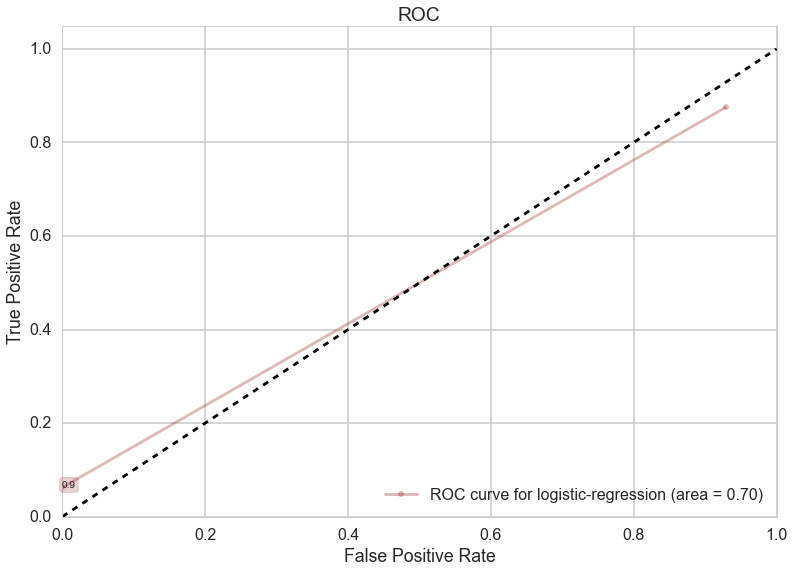

In [20]:
#with sns.hls_palette(8, l=.3, s=.8):
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-regression",clfLR, ytest, xtest, labe=200, skip=50)
#make_roc("logistic regression",clfLR, ytest, xtest, labe=3, skip=50)

In [21]:
get_

NameError: name 'get_' is not defined

In [47]:
#Define do_classify and cv_optimize, used from homework 3.
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.3f" % (training_accuracy)
    print "Accuracy on test data:     %0.3f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [188]:
# Import Logistic Regresion and grid_search from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

clfsvm=LinearSVC(loss="hinge")
Cs=[0.000001,0.00001,0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=traindf[movievars].values
Yresp=traindf['winner'].values
xtest=testdf[movievars].values
ytest=testdf['winner'].values

# Initialize classifer as Logistic Regression
clf = LogisticRegression()

# Use GridSearchCV over the parameter grid of regularization coefficients in 
# the Cs array to get the best fit classifier using 5-fold cross validation
fitmodel = GridSearchCV(clf, param_grid=dict(C=Cs), cv=5, scoring="accuracy")

# Fit over training data
fitmodel.fit(Xmatrix,Yresp)

# Find best value of C
best = fitmodel.best_params_
best

{'C': 1e-06}

In [193]:
# Import accuracy_score from sklearn
from sklearn.metrics import accuracy_score

#calculate the accuracy here
clf=LogisticRegression(C=fitmodel.best_params_['C'])
clf.fit(Xmatrix,Yresp)
ypred=clf.predict(Xmatrix)
print "Accuracy on training data: ", clf.score(Xmatrix, Yresp)
#print "Accuracy on test data: ", accuracy_score(xtest, ytest)

Accuracy on training data:  0.732428115016


In [142]:
%%time
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, traindf, movievars, u'winner',1, mask=False)

using mask


TypeError: Singleton array 0 cannot be considered a valid collection.

In [38]:
for train_index, test_index in kfdf:
    print train_index
    print test_index

[   1    2    4 ..., 1303 1304 1305]
[   0    3   26   28   30   41   51   54   59   63   83   95  100  117  146
  154  158  163  182  190  198  202  205  211  222  269  270  271  275  304
  325  331  339  364  368  375  376  381  404  405  434  436  472  491  492
  495  521  534  535  540  568  575  578  584  586  600  606  607  622  624
  631  644  647  651  653  662  667  669  673  679  681  702  717  722  743
  755  771  774  778  780  793  798  810  816  846  848  860  900  901  909
  917  919  923  925  946  957  962  969  975  976  991 1000 1018 1035 1045
 1063 1064 1092 1110 1112 1115 1118 1122 1125 1134 1149 1181 1197 1205 1210
 1211 1218 1223 1227 1238 1259 1262 1276 1287 1292 1294]
[   0    1    2 ..., 1303 1304 1305]
[   7   12   60   77   81   92  114  122  126  131  153  161  173  174  196
  204  248  249  255  268  287  296  308  312  318  320  327  342  345  349
  357  383  393  400  401  406  408  413  418  423  439  440  443  449  458
  507  526  528  542  550  555  5

### Cross Validation

In [27]:
# Import Logistic Regresion and grid_search from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

1364

#Exploratory Data Analysis

#Final Analysis

#Presentation